In [77]:
###############################################
# Model for: How ethnic distribution affects
# English and Math achievement
# Using Random Forest + Correlation Analysis
###############################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OPTIONAL: nicer plots
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# 1. Load and clean data

In [78]:

path_states_all_ext = "states_all_extended.csv"
df_raw = pd.read_csv(path_states_all_ext)

# Rough equivalent of janitor::clean_names()
df = df_raw.copy()
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
      .str.replace(r'[^0-9a-zA-Z_]', '', regex=True)
)

# 2. Rename outcome variables more clearly

In [79]:

df["math_score"] = df["g08_a_a_mathematics"]
df["reading_score"] = df["g08_a_a_reading"]

# 3. Construct racial counts and fill missing with 0

In [80]:

race_codes = ["am", "as", "hi", "bl", "wh", "hp", "tr"]

# select relevant grade 8 columns
g08_cols = [c for c in df.columns if c.startswith("g08_") and c != "g08_a_a"]

grade8_df = df[
    ["state", "year", "g08_a_a",
     "math_score", "reading_score",
     "total_expenditure", "enroll"] + g08_cols
].copy()

grade8_df = grade8_df.dropna(
    subset=["state", "year", "g08_a_a", "math_score", "reading_score"]
)
grade8_df = grade8_df[grade8_df["g08_a_a"] > 0]

# Identify race count columns like g08_wh_f, g08_wh_m etc.
race_count_cols = grade8_df.filter(
    regex=r"^g08_(am|as|hi|bl|wh|hp|tr)_(f|m)$"
).columns.tolist()

# Replace NA with 0 for these counts
grade8_df[race_count_cols] = grade8_df[race_count_cols].fillna(0)

# 4. Compute racial shares (rename variables to readable names)


In [81]:

rename_map = {
    "am": "native",
    "as": "asian",
    "hi": "hispanic",
    "bl": "black",
    "wh": "white",
    "hp": "pacific",
    "tr": "multirace",
}

for race in race_codes:
    col_f = f"g08_{race}_f"
    col_m = f"g08_{race}_m"
    new_nm = f"pct_{rename_map[race]}"
    grade8_df[new_nm] = (grade8_df[col_f] + grade8_df[col_m]) / grade8_df["g08_a_a"]

# 5. Construct per-pupil expenditure and finalize modeling data

In [82]:

grade8_df["exp_per_pupil"] = grade8_df["total_expenditure"] / grade8_df["enroll"]
grade8_df = grade8_df[np.isfinite(grade8_df["exp_per_pupil"])]

# Modeling dataset (no grade labels in names)
race_share_vars = grade8_df.filter(regex=r"^pct_").columns.tolist()

df_model_raw = grade8_df[
    ["year", "state", "math_score", "reading_score"] +
    race_share_vars + ["exp_per_pupil"]
].copy()

n_before = len(df_model_raw)
df_model = df_model_raw.dropna()
n_after = len(df_model)
n_dropped = n_before - n_after

print("Rows before:", n_before)
print("Rows after drop_na:", n_after)
print("Dropped rows:", n_dropped)

# R: year = factor(year)
df_model["year"] = df_model["year"].astype("category")
df_model["state"] = df_model["state"].astype("category")

Rows before: 357
Rows after drop_na: 357
Dropped rows: 0


# 6. Split dataset

In [83]:

# Build feature matrix (with one-hot encoding for year)
feature_cols = race_share_vars + ["exp_per_pupil", "year", "state"]

X = df_model[feature_cols].copy()
X = pd.get_dummies(X, columns=["year"], drop_first=True)  # like factor in R
X = pd.get_dummies(X, columns=["state"], drop_first=True)  # like factor in R
y_math = df_model["math_score"].values
y_read = df_model["reading_score"].values

X_train, X_test, y_train_math, y_test_math = train_test_split(
    X, y_math, train_size=0.8, random_state=123
)
# use the same split for reading
_, _, y_train_read, y_test_read = train_test_split(
    X, y_read, train_size=0.8, random_state=123
)

# 7. Random Forest (Math) with permutation importance


In [84]:

rf_math = RandomForestRegressor(
    n_estimators=1000,
    max_features=5,
    random_state=123,
    n_jobs=-1
)

rf_math.fit(X_train, y_train_math)

print(rf_math)

pred_math = rf_math.predict(X_test)
rmse_math = np.sqrt(mean_squared_error(y_test_math, pred_math))
print("Math RMSE:", rmse_math)

# Permutation importance to approximate %IncMSE
result_math = permutation_importance(
    rf_math, X_test, y_test_math,
    n_repeats=30,
    random_state=123,
    scoring="neg_mean_squared_error"
)

baseline_mse_math = mean_squared_error(y_test_math, pred_math)
inc_mse_math = result_math.importances_mean  # increase in MSE
pct_incmse_math = 100 * inc_mse_math / baseline_mse_math

importance_math = (
    pd.DataFrame({
        "variable": X.columns,
        "incmse": pct_incmse_math
    })
    .sort_values("incmse", ascending=False)
    .reset_index(drop=True)
)

RandomForestRegressor(max_features=5, n_estimators=1000, n_jobs=-1,
                      random_state=123)
Math RMSE: 4.936188169152633


In [85]:
importance_math

,variable,incmse
0,state_DISTRICT_OF_COLUMBIA,72.765150
1,exp_per_pupil,44.639511
2,pct_white,38.727094
3,pct_asian,28.589888
4,pct_native,14.285024
...,...,...
59,state_NORTH_DAKOTA,0.000000
60,state_NEBRASKA,0.000000
61,state_PENNSYLVANIA,-0.104025
62,state_MAINE,-0.324399


                      variable     incmse
0   state_DISTRICT_OF_COLUMBIA  72.765150
1                exp_per_pupil  44.639511
2                    pct_white  38.727094
3                    pct_asian  28.589888
4                   pct_native  14.285024
..                         ...        ...
59          state_NORTH_DAKOTA   0.000000
60              state_NEBRASKA   0.000000
61          state_PENNSYLVANIA  -0.104025
62                 state_MAINE  -0.324399
63                   year_2005  -7.411938

[64 rows x 2 columns]


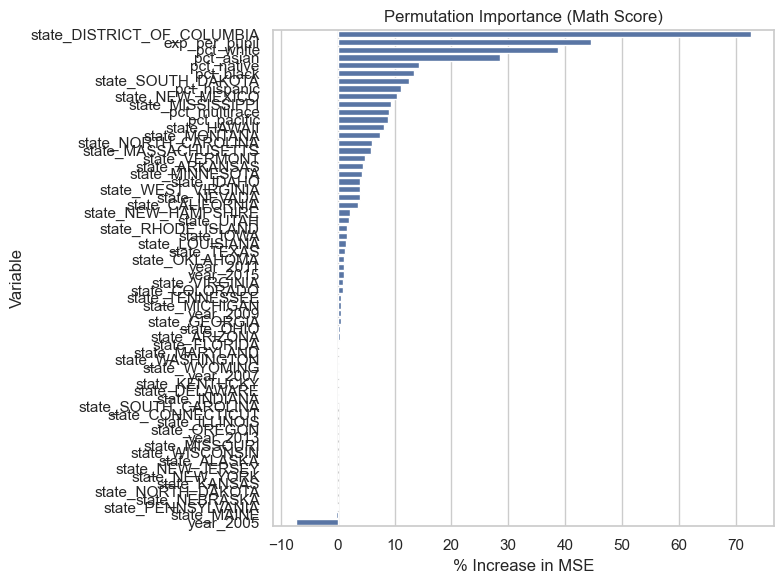

In [86]:

print(importance_math)

# Plot permutation importance (Math)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importance_math,
    x="incmse",
    y="variable"
)
plt.title("Permutation Importance (Math Score)")
plt.xlabel("% Increase in MSE")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# 8. Random Forest (Reading)

In [87]:

rf_reading = RandomForestRegressor(
    n_estimators=1000,
    max_features=5,
    random_state=123,
    n_jobs=-1
)

rf_reading.fit(X_train, y_train_read)

print(rf_reading)

pred_read = rf_reading.predict(X_test)
rmse_read = np.sqrt(mean_squared_error(y_test_read, pred_read))
print("Reading RMSE:", rmse_read)

result_read = permutation_importance(
    rf_reading, X_test, y_test_read,
    n_repeats=30,
    random_state=123,
    scoring="neg_mean_squared_error"
)

baseline_mse_read = mean_squared_error(y_test_read, pred_read)
inc_mse_read = result_read.importances_mean
pct_incmse_read = 100 * inc_mse_read / baseline_mse_read

importance_read = (
    pd.DataFrame({
        "variable": X.columns,
        "incmse": pct_incmse_read
    })
    .sort_values("incmse", ascending=False)
    .reset_index(drop=True)
)

RandomForestRegressor(max_features=5, n_estimators=1000, n_jobs=-1,
                      random_state=123)
Reading RMSE: 3.608961974631545


                      variable     incmse
0   state_DISTRICT_OF_COLUMBIA  74.315235
1                    pct_white  48.693577
2                exp_per_pupil  27.296899
3                    pct_asian  19.064683
4                 state_HAWAII  15.075477
..                         ...        ...
59                state_OREGON  -0.023127
60              state_MISSOURI  -0.095352
61               state_INDIANA  -0.184292
62                   year_2005  -6.573551
63                   year_2007  -6.861985

[64 rows x 2 columns]


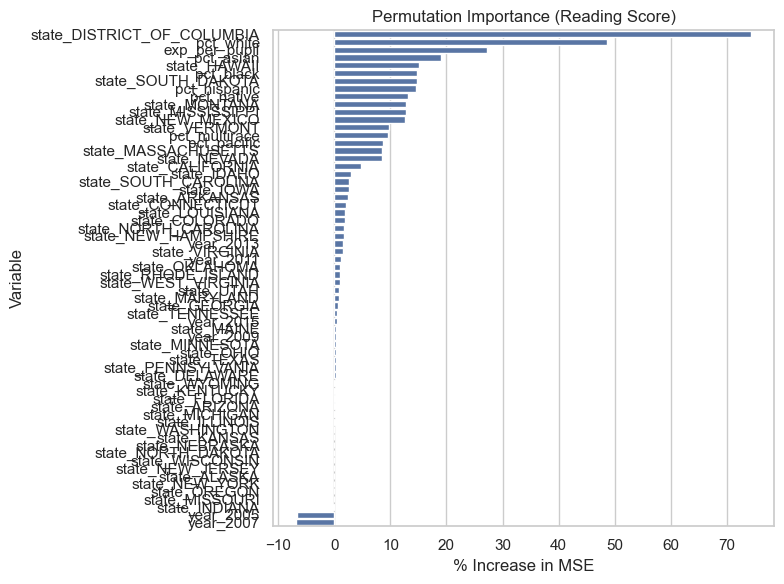

In [88]:

print(importance_read)

# Plot permutation importance (Reading)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importance_read,
    x="incmse",
    y="variable"
)
plt.title("Permutation Importance (Reading Score)")
plt.xlabel("% Increase in MSE")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


# 9. Correlation Analysis (with readable names)

In [89]:

# racial share variables already readable:
# pct_white, pct_black, pct_asian, pct_hispanic, pct_native,
# pct_pacific, pct_multirace

corr_vars = race_share_vars + ["exp_per_pupil"]

# Compute correlations
cor_math = df_model[corr_vars].apply(
    lambda col: col.corr(df_model["math_score"])
)
cor_read = df_model[corr_vars].apply(
    lambda col: col.corr(df_model["reading_score"])
)

# Build nice dataframe
cor_df = pd.DataFrame({
    "variable": corr_vars,
    "math_corr": cor_math.values,
    "reading_corr": cor_read.values
})

cor_df["abs_math_corr"] = cor_df["math_corr"].abs()
cor_df["abs_read_corr"] = cor_df["reading_corr"].abs()
cor_df["variable"] = pd.Categorical(
    cor_df["variable"],
    categories=corr_vars,
    ordered=True
)

In [90]:

print(cor_df)

        variable  math_corr  reading_corr  abs_math_corr  abs_read_corr
0     pct_native   0.083887      0.007687       0.083887       0.007687
1      pct_asian   0.084999      0.005760       0.084999       0.005760
2   pct_hispanic   0.076189      0.003942       0.076189       0.003942
3      pct_black  -0.182848     -0.217873       0.182848       0.217873
4      pct_white   0.400987      0.381511       0.400987       0.381511
5    pct_pacific  -0.010765     -0.073858       0.010765       0.073858
6  pct_multirace   0.201242      0.163487       0.201242       0.163487
7  exp_per_pupil   0.208137      0.183449       0.208137       0.183449



# 10. Correlation Plot (Bar chart, very readable)

In [109]:
# Compute a sorting key (average absolute correlation)
# Keep only racial share variables (drop exp_per_pupil)
cor_df_race = cor_df[cor_df["variable"].isin(race_share_vars)].copy()

cor_df_race["sort_key"] = (
    cor_df_race[["math_corr", "reading_corr"]]
    .abs()
    .mean(axis=1)
)

# Sort in descending order
cor_df_race = cor_df_race.sort_values("sort_key", ascending=False)

# Re-set factor levels so seaborn respects the order
cor_df_race["variable"] = pd.Categorical(
    cor_df_race["variable"],
    categories=cor_df_race["variable"].tolist(),
    ordered=True
)



In [ ]:
# Compute a sorting key (average absolute correlation)
cor_df_race["sort_key"] = (
    cor_df_race[["math_corr", "reading_corr"]]
    .abs()
    .mean(axis=1)
)

# Sort in descending order
cor_df_race = cor_df_race.sort_values("sort_key", ascending=False)

# Re-set factor levels so seaborn respects the order
cor_df_race["variable"] = pd.Categorical(
    cor_df_race["variable"],
    categories=cor_df_race["variable"].tolist(),
    ordered=True
)


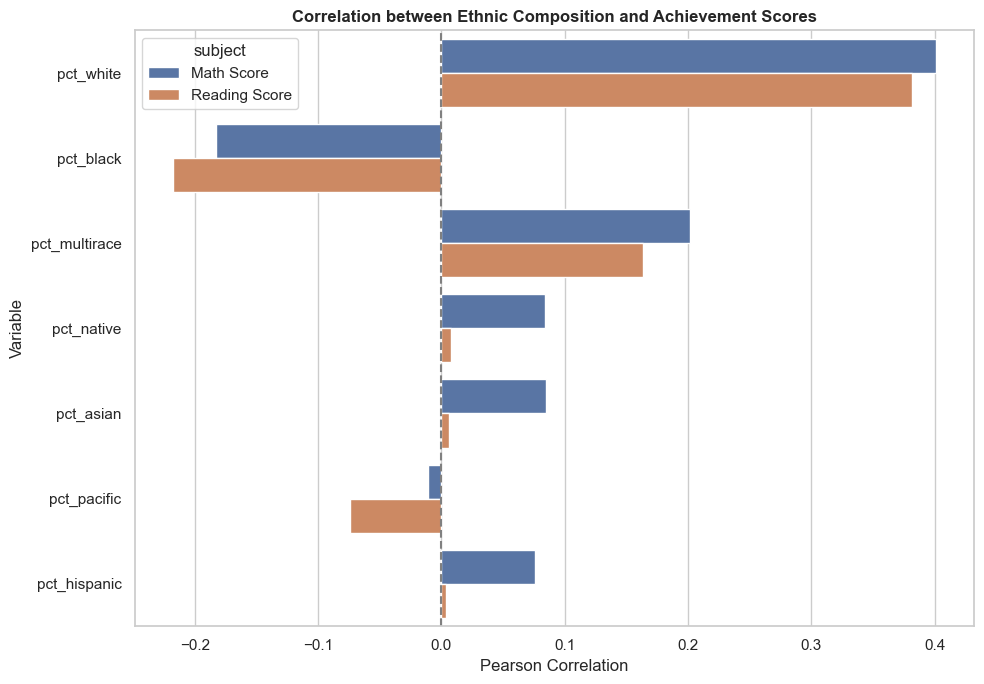

In [110]:
cor_long = cor_df_race.melt(
    id_vars="variable",
    value_vars=["math_corr", "reading_corr"],
    var_name="subject",
    value_name="correlation"
)

cor_long["subject"] = cor_long["subject"].map({
    "math_corr": "Math Score",
    "reading_corr": "Reading Score"
})

plt.figure(figsize=(10, 7))
sns.barplot(
    data=cor_long,
    x="correlation",
    y="variable",
    hue="subject",
    orient="h",
    palette=["#4C72B0", "#DD8452"]
)

plt.axvline(0, linestyle="--", color="gray")
plt.title("Correlation between Ethnic Composition and Achievement Scores", fontweight="bold")
plt.xlabel("Pearson Correlation")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [93]:

###############################################
# Optional: export correlation data
###############################################

cor_df.to_csv("racial_correlations_math_reading.csv", index=False)


# 11. Modified plots

In [94]:
# Keep only ethnic composition variables in the importance table
importance_math_race = (
    importance_math[importance_math["variable"].isin(race_share_vars)]
    .sort_values("incmse", ascending=False)
    .reset_index(drop=True)
)

importance_read_race = (
    importance_read[importance_read["variable"].isin(race_share_vars)]
    .sort_values("incmse", ascending=False)
    .reset_index(drop=True)
)


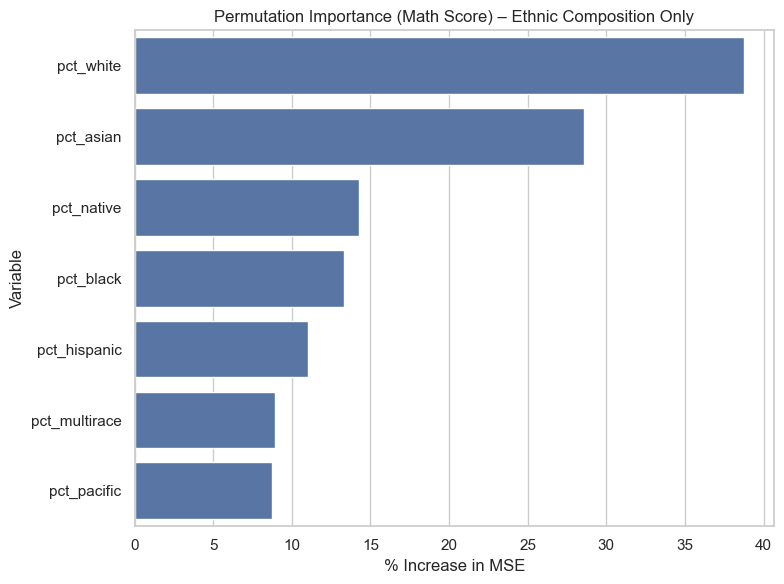

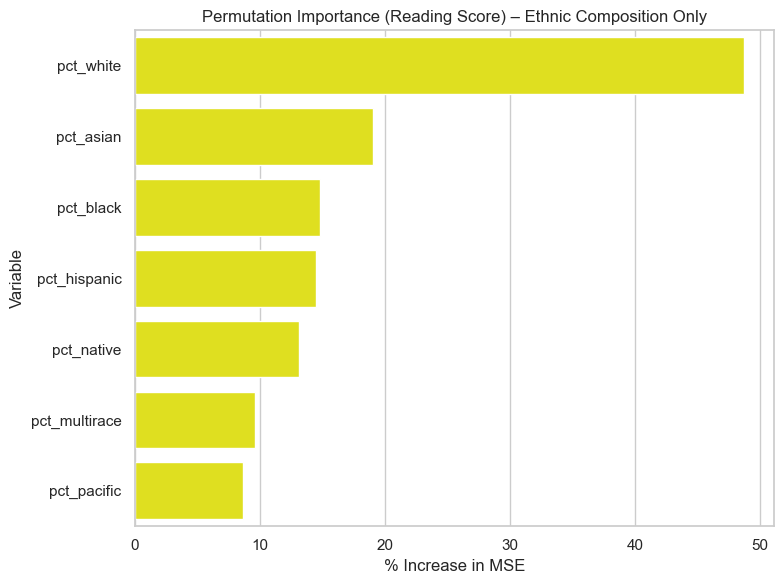

In [114]:
# Math importance plot: only ethnic distribution
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importance_math_race,
    x="incmse",
    y="variable"
)
plt.title("Permutation Importance (Math Score) – Ethnic Composition Only")
plt.xlabel("% Increase in MSE")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Reading importance plot: only ethnic distribution
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importance_read_race,
    x="incmse",
    y="variable",
    color="yellow"
)
plt.title("Permutation Importance (Reading Score) – Ethnic Composition Only")
plt.xlabel("% Increase in MSE")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [111]:
# Keep only racial share variables (drop exp_per_pupil)
cor_df_race = cor_df[cor_df["variable"].isin(race_share_vars)].copy()
cor_long_race = cor_df_race.melt(
    id_vars="variable",
    value_vars=["math_corr", "reading_corr"],
    var_name="subject",
    value_name="correlation"
)

cor_long_race["subject"] = cor_long_race["subject"].map({
    "math_corr": "Math Score",
    "reading_corr": "Reading Score"
})


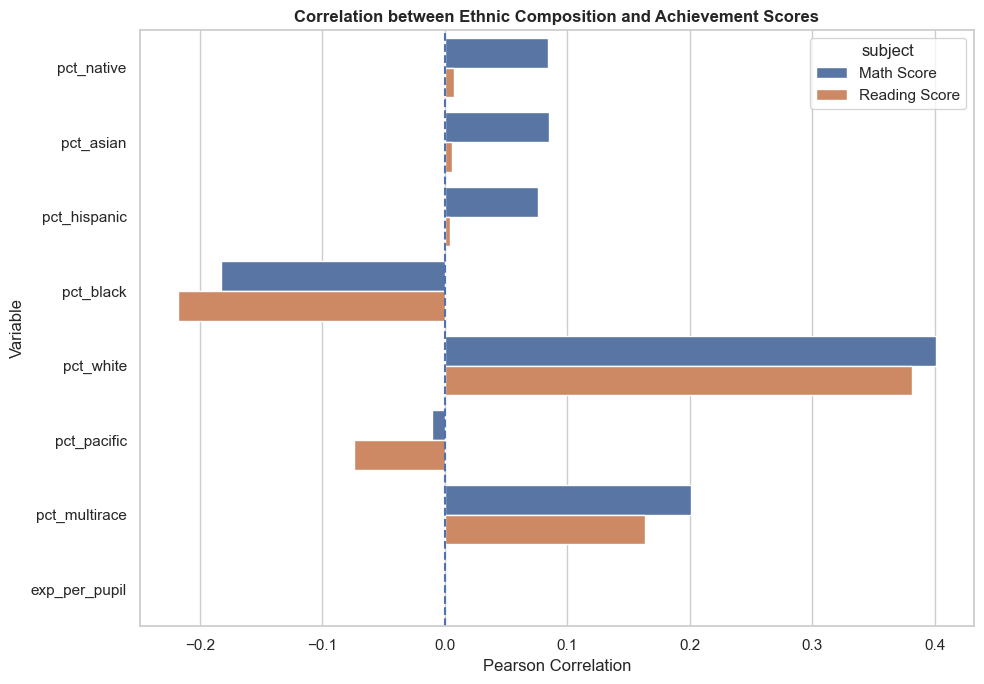

In [112]:
plt.figure(figsize=(10, 7))
sns.barplot(
    data=cor_long_race,
    x="correlation",
    y="variable",
    hue="subject",
    orient="h",
    palette=["#4C72B0", "#DD8452"]
)
plt.axvline(0, linestyle="--")
plt.title("Correlation between Ethnic Composition and Achievement Scores", fontweight="bold")
plt.xlabel("Pearson Correlation")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


# 12. Correlation by years

In [ ]:
# List of racial share variables (already computed earlier)
race_vars = race_share_vars  # same as pct_white, pct_black, pct_asian, ...

# Unique years
years = sorted(df_model["year"].astype(int).unique())

# Store results
corr_yearly_math = []
corr_yearly_read = []

for yr in years:
    df_y = df_model[df_model["year"].astype(int) == yr]

    # Compute correlations for each race share
    for race in race_vars:
        corr_math = df_y[race].corr(df_y["math_score"])
        corr_read = df_y[race].corr(df_y["reading_score"])

        corr_yearly_math.append({
            "year": yr,
            "variable": race,
            "correlation": corr_math
        })
        corr_yearly_read.append({
            "year": yr,
            "variable": race,
            "correlation": corr_read
        })

corr_math_df = pd.DataFrame(corr_yearly_math)
corr_read_df = pd.DataFrame(corr_yearly_read)


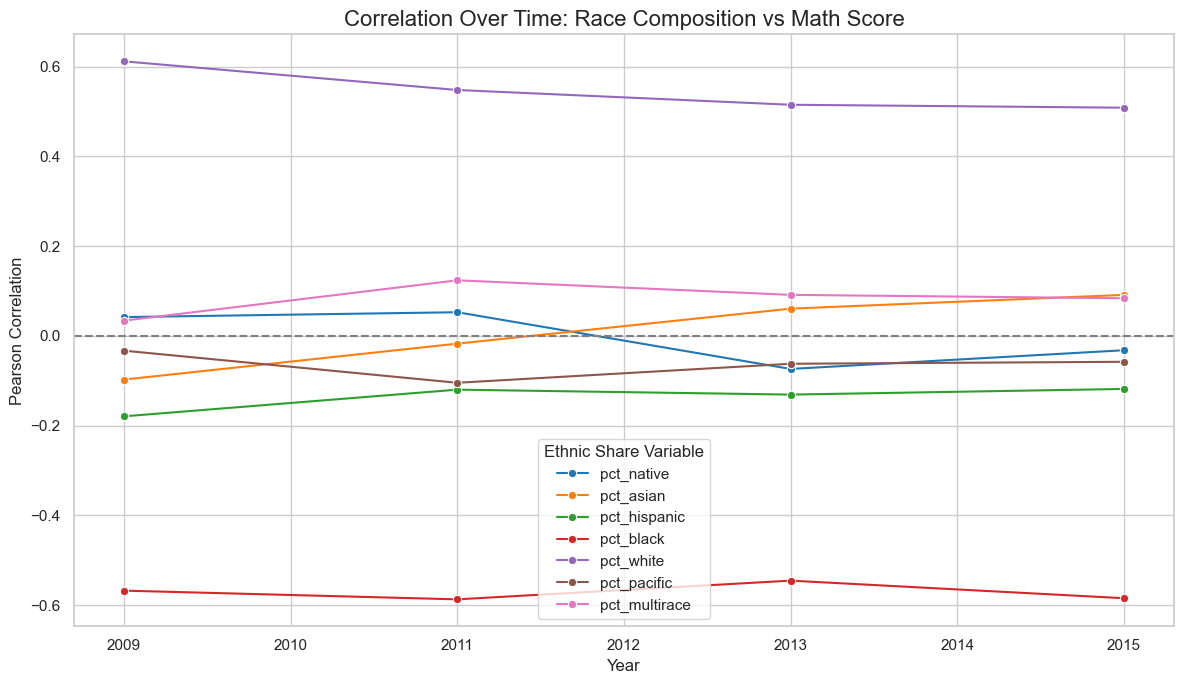

In [97]:
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=corr_math_df,
    x="year",
    y="correlation",
    hue="variable",
    palette="tab10",
    marker="o"
)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Correlation Over Time: Race Composition vs Math Score", fontsize=16)
plt.ylabel("Pearson Correlation")
plt.xlabel("Year")
plt.legend(title="Ethnic Share Variable")
plt.tight_layout()
plt.show()


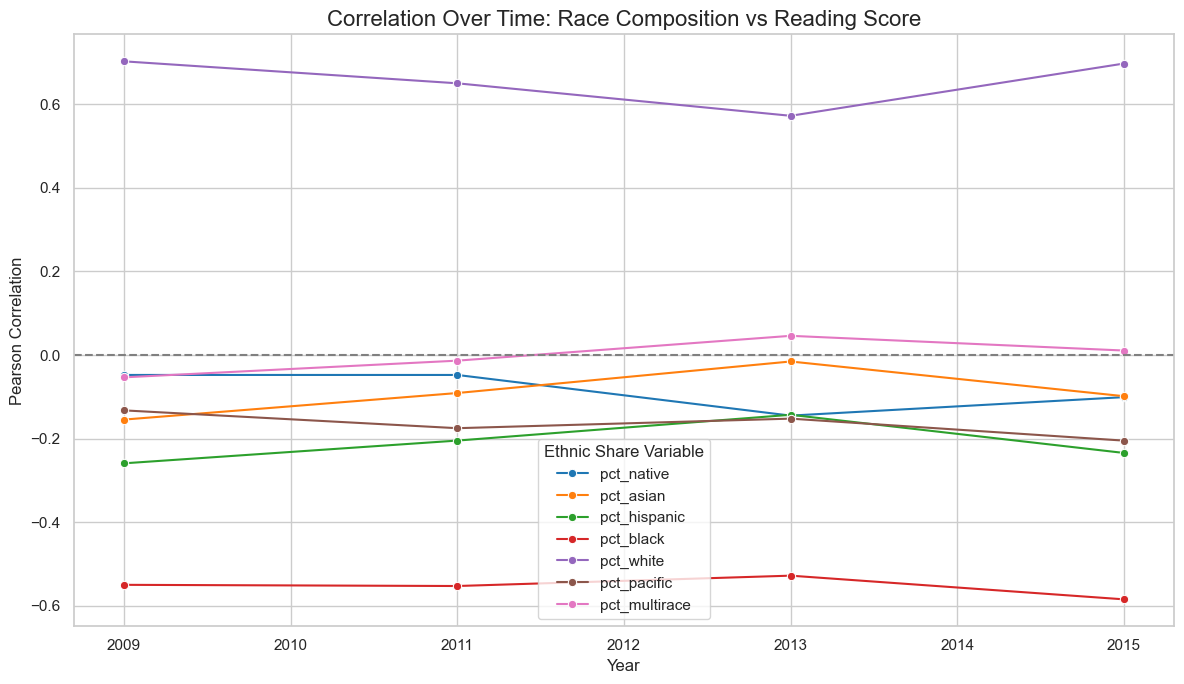

In [98]:
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=corr_read_df,
    x="year",
    y="correlation",
    hue="variable",
    palette="tab10",
    marker="o"
)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Correlation Over Time: Race Composition vs Reading Score", fontsize=16)
plt.ylabel("Pearson Correlation")
plt.xlabel("Year")
plt.legend(title="Ethnic Share Variable")
plt.tight_layout()
plt.show()
